# Demonstration of the Renewable Resource and Power Data Tool to the RTS-GMLC System

In [42]:
import logging
import os
cwd = os.getcwd()
from subprocess import check_output, list2cmdline

import numpy as np
import pandas as pds

import sys
sys.path.append('/Users/mrossol/Documents/Smart_DS/R2PD')
import R2PD
import time

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
%matplotlib inline

logging.basicConfig()

def print_cli_call_and_output(cmds):
    print(list2cmdline(cmds) + "\n")
    stdout = check_output(cmds)
    print(stdout.decode('utf-8'))
    
def multi_index(df, cols):
    result = df.copy()
    result.index = result[cols[0]] if len(cols) == 1 else pds.MultiIndex.from_tuples(list(zip(*[result[col].tolist() for col in cols])),names = cols)
    for col in cols:
        del result[col]
    return result 

[Extract Resource Data](#Extract-Resouce-Data-for-RTS-GMLC)

## Extract Resouce Data for RTS-GMLC

### Format RTS System

In [2]:
rts_dir = os.path.join(cwd, 'RTS-GMLC','RTS_Data')

gentypes_map = {
    'Oil CT': 'Oil-Gas-Steam',
    'Coal': 'Coal',
    'Gas CC': 'NG-CC',
    'Gas CT': 'NG-CT',
    'Oil ST': 'Oil-Gas-Steam',
    'Sync_Cond': None,
    'Nuclear': 'Nuclear',
    'Hydro': 'Hydro',
    'Solar': 'Utility PV',
    'CSP': 'CSP',
    'Wind': 'Land-based Wind',
    'Storage': 'Storage'
}

solar_map = {'PV': 'Utility PV', 'RTPV': 'Rooftop PV'}

#### Nodes

In [3]:
nodes = pds.read_csv(os.path.join(rts_dir,'SourceData','bus.csv'))
nodes = nodes[['Bus ID','lat','lng']]
nodes.columns = ['node_id','latitude','longitude']

print(nodes.head())

   node_id   latitude   longitude
0      101  33.396103 -113.835642
1      102  33.357678 -113.825933
2      103  33.536833 -114.670399
3      104  33.812304 -113.825419
4      105  33.659560 -113.999023


#### Generators

In [4]:
generators = pds.read_csv(os.path.join(rts_dir,'SourceData','gen.csv'))
generators['generator type'] = generators['Category'].map(gentypes_map)
solar = generators['generator type'] == 'Utility PV'
generators.loc[solar, 'generator type'] = generators.loc[solar, 'Unit Type'].map(solar_map)
generators = generators[['Bus ID','generator type','PMax MW']]
generators.columns = ['node_id','generator type','capacity']
# drop un-mapped generators (synchronous condensors)
generators = generators.dropna(axis=0,subset=['generator type'],how='all')
generators = generators.groupby(['node_id', 'generator type']).sum().reset_index()

generators.head()

,node_id,generator type,capacity
0,101,Coal,152.0
1,101,Oil-Gas-Steam,40.0
2,101,Utility PV,104.6
3,102,Coal,152.0
4,102,Oil-Gas-Steam,40.0


#### Renewable Generator node inputs for R2PD

In [5]:
RE_nodes = pds.merge(nodes, generators, on='node_id', how='inner')

wind_nodes = RE_nodes[RE_nodes['generator type'] == 'Land-based Wind'][['node_id','latitude','longitude','capacity']]
PV_nodes = RE_nodes[RE_nodes['generator type'] == 'Utility PV'][['node_id','latitude','longitude','capacity']]
RTPV_nodes = RE_nodes[RE_nodes['generator type'] == 'Rooftop PV'][['node_id','latitude','longitude','capacity']]

In [6]:
NodeClass = R2PD.powerdata.SolarGeneratorNode
node_list = [NodeClass(*tuple(node_info)) for _, node_info in PV_nodes.iterrows()]
PV_nodes = R2PD.NodeCollection.factory(node_list)

PV_nodes

GeneratorNodeCollection contains 14 nodes

In [7]:
NodeClass = R2PD.powerdata.SolarGeneratorNode
node_list = [NodeClass(*tuple(node_info)) for _, node_info in RTPV_nodes.iterrows()]
RTPV_nodes = R2PD.NodeCollection.factory(node_list)

RTPV_nodes

GeneratorNodeCollection contains 5 nodes

In [8]:
NodeClass = R2PD.WindGeneratorNode
node_list = [NodeClass(*tuple(node_info)) for _, node_info in wind_nodes.iterrows()]
wind_nodes = R2PD.NodeCollection.factory(node_list)

wind_nodes

GeneratorNodeCollection contains 4 nodes

#### Initialize connection to repositories

In [9]:
config_path = '/Users/mrossol/Documents/Smart_DS/repo_config.ini'

repo = R2PD.datastore.Peregrine.connect(config_path)

#### Get Wind Resource

In [10]:
ts = time.time()
wind_nodes = R2PD.queue.get_resource_data(wind_nodes, repo)
print('Time to download wind resource = {:.4f} min'.format((time.time() - ts) / 60 ))

RuntimeError: Download failed, check inputs!

/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


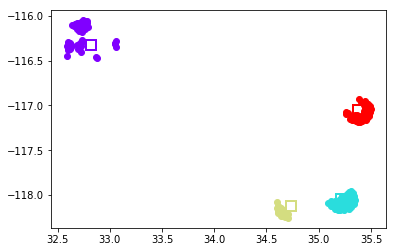

In [111]:
nearest_nodes = nearest_wind
re_resource = wind_meta

color=iter(plt.cm.rainbow(np.linspace(0,1, len(nearest_node))))
for i, meta in nearest_nodes.iterrows():
    node = meta[['lat', 'lon']]
    resource = re_resource.loc[meta['site_ids']].as_matrix(['latitude', 'longitude'])
    c = next(color)
    plt.plot(node[0], node[1], color=c, marker='s', linestyle='', markersize=10,
             markeredgewidth=2, markeredgecolor=c, markerfacecolor='None')
    plt.plot(resource[:, 0], resource[:, 1], color=c, marker='o', linestyle='')
                              
plt.show()

In [10]:
ts = time.time()
PV_nodes = R2PD.queue.get_resource_data(PV_nodes, repo)
print('Time to download Utility PV resource = {:.4f} min'.format((time.time() - ts) / 60 ))

Time to download wind resource = 0.0382 min


In [40]:
ts = time.time()
RTPV_nodes = R2PD.queue.get_resource_data(RTPV_nodes, repo)
print('Time to download Rooftop PV resource = {:.4f} min'.format((time.time() - ts) / 60 ))

Time to download Rooftop PV resource = 0.9057 min


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


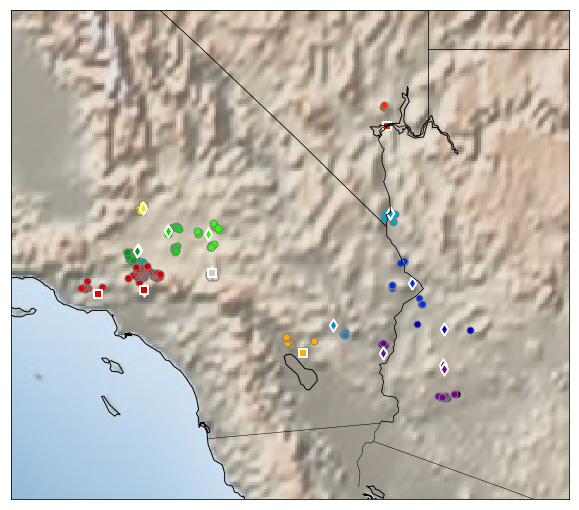

In [47]:
total_nodes = len(PV_nodes) + len(RTPV_nodes)

buffersize = 1
color=iter(plt.cm.nipy_spectral(np.linspace(0,1, total_nodes)))
plt.figure(figsize=(10,10))
m = Basemap(
        projection='merc',
        llcrnrlon=min(nodes['longitude']-buffersize),
        llcrnrlat=min(nodes['latitude']-buffersize),
        urcrnrlon=max(nodes['longitude']+buffersize),
        urcrnrlat=max(nodes['latitude']+buffersize),
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)


m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief()
for node in PV_nodes.nodes:
    c = next(color)
    resource_loc = node._resource.locations
    re_long, re_lat = m(resource_loc[:, 1], resource_loc[:, 0])
    m.scatter(re_long, re_lat, 50, marker='o', facecolors=c, edgecolors='0.5', linewidth=1)
    
    node_long, node_lat = m(node.longitude, node.latitude)
    m.scatter(node_long, node_lat, 75, marker='d', facecolors=c, edgecolors='w', linewidth=2)
    
for node in RTPV_nodes.nodes:
    c = next(color)
    resource_loc = node._resource.locations
    re_long, re_lat = m(resource_loc[:, 1], resource_loc[:, 0])
    m.scatter(re_long, re_lat, 50, marker='o', facecolors=c, edgecolors='0.5', linewidth=1)
    
    node_long, node_lat = m(node.longitude, node.latitude)
    m.scatter(node_long, node_lat, 75, marker='s', facecolors=c, edgecolors='w', linewidth=2)

plt.show()
plt.close()